In [2]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as ax
import pandas as pd
import geopandas as gpd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
from obspy.core import UTCDateTime
import os
from obspy.clients.fdsn import Client
import pygmt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf
from scipy.stats import shapiro, bartlett, pearsonr, boxcox, spearmanr
from scipy.linalg import toeplitz
from scipy.ndimage import uniform_filter1d

# Read Sequence Event Data

In [3]:
# define cwd
cwd = os.getcwd()

# read data
repeaters = pd.read_csv(cwd+"/DD_Repeat.txt", sep='\s+', header = 1)

# split sequence family headers from sequence events
# repeater events
seq = repeaters[repeaters["YR"] == "#"]
seq = seq.drop(columns=["DMAGE","CCm","evID"])
seq = seq.rename(columns={"YR":"#","MO":"NEV","DY":"LATm","HR":"LONm","MN":"DEPm","SC":"DMAGm","DAYS":"DMAGs","LAT":"RCm",
                    "LON":"RCs","DEP":"RCcv","EX":"RCm1","EY":"RCs1","EZ":"RCcv1","MAG":"CCm","DMAG":"seqID"})
seq = seq.reset_index()

# sequence families
repeaters = repeaters[repeaters["YR"] != "#"]

# Add SeqID column to Repeaters

In [4]:
seq_ID = []
for i in range(len(seq)):
    ID = np.full(seq["NEV"][i], seq["seqID"][i])
    for j in range(len(ID)):
        seq_ID.append(ID[j])

repeaters["seqID"] = seq_ID

# Read XMR1 Creepmeeter Data

In [5]:
XMR1 = pd.read_csv(cwd + "/Creepmeters/xmr1.day", delim_whitespace=True, names = ["YR", "DAY", "DIST"])

# format time variable to decyr
Decyr = []
for i in range(len(XMR1["YR"])):
    if XMR1["YR"][i] % 4 ==0:
        Decyr.append(XMR1["YR"][i].astype(float) + (XMR1["DAY"][i].astype(float)/366))
    else:
        Decyr.append(XMR1["YR"][i].astype(float) + (XMR1["DAY"][i].astype(float)/365))
XMR1["DECYR"] = Decyr

# UTC Time
dt = []
for i in range(len(XMR1["DECYR"])):
    dt.append(UTCDateTime(year = XMR1["YR"][i], julday = int(XMR1["DAY"][i])))
dt = np.array(dt).astype(float)/(24*3600)
XMR1["DT"] = dt

# Define Parameters

In [6]:
NC_bounds = [-121.5380,-120.4327,35.8997,36.8455] # window for map figure
XMR_bounds = [-121.244,-121.130,36.54,36.65] # window for data being considered
XMR_lon = [XMR_bounds[0],XMR_bounds[0],XMR_bounds[1],XMR_bounds[1],XMR_bounds[0]]
XMR_lat = [XMR_bounds[3],XMR_bounds[2],XMR_bounds[2],XMR_bounds[3],XMR_bounds[3]] # for later processing

# Select Repeater Data for Map Figure

In [7]:
# repeaters
sel_lat2 = np.logical_and(repeaters["LAT"] >= NC_bounds[2], repeaters["LAT"] <= NC_bounds[3])
sel_lon2 = np.logical_and(repeaters["LON"] >= NC_bounds[0], repeaters["LON"] <= NC_bounds[1])
rep_NC = repeaters[sel_lat2][sel_lon2]
rep_NC = rep_NC.reset_index()

# Make sure data is in right format
rep_NC["YR"] = rep_NC["YR"].astype(int)
rep_NC["MO"] = rep_NC["MO"].astype(int)
rep_NC["LAT"] = rep_NC["LAT"].astype(float)
rep_NC["LON"] = rep_NC["LON"].astype(float)

# sequence families
sel_seqlat = np.logical_and(seq["LATm"] >= NC_bounds[2], seq["LATm"] <= NC_bounds[3])
sel_seqlon = np.logical_and(seq["LONm"] >= NC_bounds[0], seq["LONm"] <= NC_bounds[1])
seq = seq[sel_seqlat][sel_seqlon]
seq = seq.reset_index()
seq = seq.rename(columns={"level_0":"level_1"})

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3531038201.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rep_NC = repeaters[sel_lat2][sel_lon2]
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3531038201.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq = seq[sel_seqlat][sel_seqlon]


# Only Select Repeating Families with Cluster Behavior

In [8]:
sel_burst = np.logical_and(pd.isnull(seq["RCcv"]), seq["RCm"] <=100)
sel_burst = np.logical_or(seq["RCcv"] >=1.2, sel_burst)
sel_burst = np.logical_and(sel_burst, pd.isnull(seq["RCcv1"]))

sel_char = np.logical_not(sel_burst)

char = seq[sel_char] # selects characteristic/periodic repeating families, for comparison to main dataset
char = char.reset_index()
char = char.rename(columns={"level_0":"level_2"})

seq = seq[sel_burst] # selects burst-like/nonperidic repeating families, main dataset
seq = seq.reset_index()
seq = seq.rename(columns={"level_0":"level_2"})
print(seq)

     level_2  level_1  index  #  NEV     LATm      LONm   DEPm  DMAGm  DMAGs  \
0         55      112    848  #    3  36.6021 -121.2077  5.807   1.07   0.16   
1         88      165   1114  #    3  36.6866 -121.3181  4.187   0.92   0.18   
2         93      173   1150  #    3  36.6894 -121.3223  5.030   0.97   0.17   
3         95      178   1170  #    3  36.5769 -121.1530  3.293   0.95   0.11   
4        112      239   1415  #    2  36.7122 -121.2300  8.485   0.76   0.11   
..       ...      ...    ... ..  ...      ...       ...    ...    ...    ...   
385     2420     7635  35145  #    3  36.7758 -121.4976  7.453   2.72   0.16   
386     2421     7636  35149  #    2  36.8436 -121.3019  6.610   3.33   0.13   
387     2422     7654  35204  #    2  36.7450 -121.3397  8.095   3.04   0.24   
388     2423     7658  35216  #    2  36.5559 -121.1166  4.669   3.13   0.08   
389     2427     7710  35378  #    2  36.6273 -121.2344  5.139   3.54   0.01   

        RCm     RCs  RCcv   RCm1  RCs1 

# Make Map Figure

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


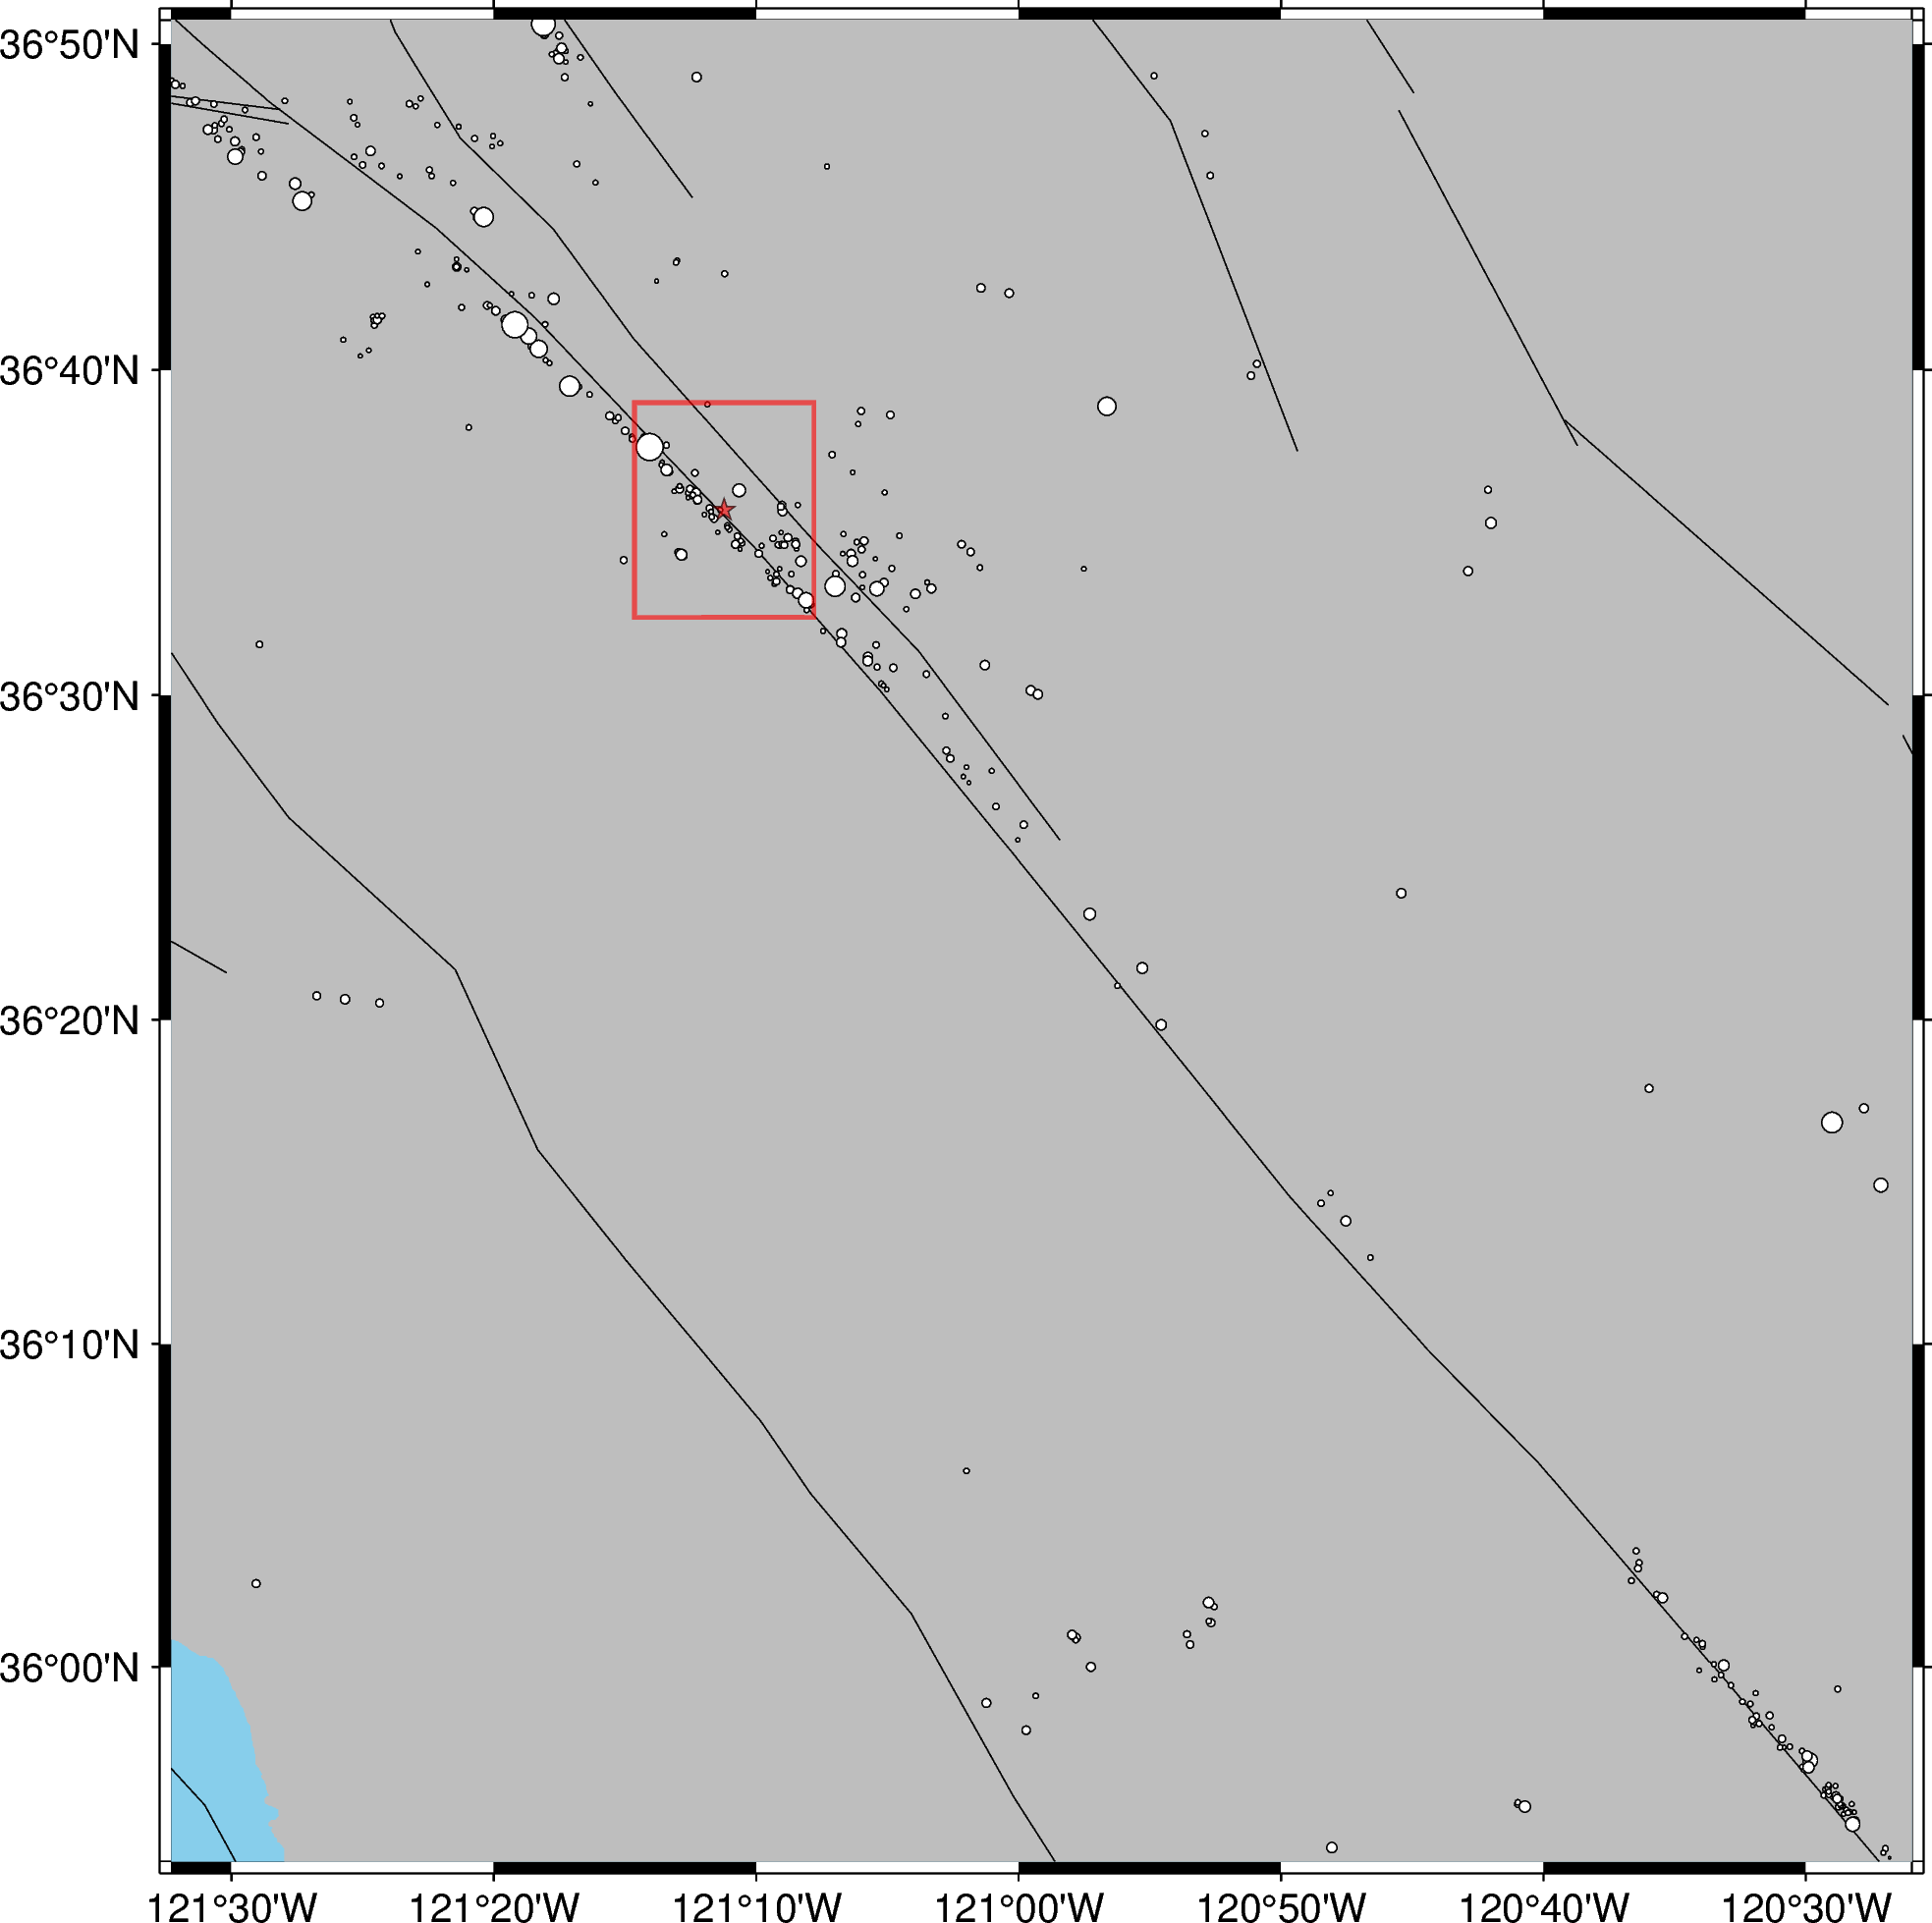

In [187]:
# read faults data for plotting
faults = gpd.read_file(cwd+"/faults/gem_active_faults.shp")
#plot
fig = pygmt.Figure()
fig.basemap(region=NC_bounds, projection="M15c", frame=["a"])
fig.coast(land="gray", water="skyblue")
#faults
fig.plot(data=faults)
# plot sequences
fig.plot(x=seq["LONm"], y=seq["LATm"], size=0.02 * (2**seq["DMAGm"]),style="cc", color="white", pen="black")
# plot window for data being considered
fig.plot(x=XMR_lon,y=XMR_lat, pen = "1p,red", transparency=40)
# plot XMR1 station
fig.plot(x=-121.1870,y=36.5950, style="a0.2c", color="red",pen ="black", transparency=40)
fig.savefig(cwd + "/Watson_OCEA267_Final_1.png")
fig.show()

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


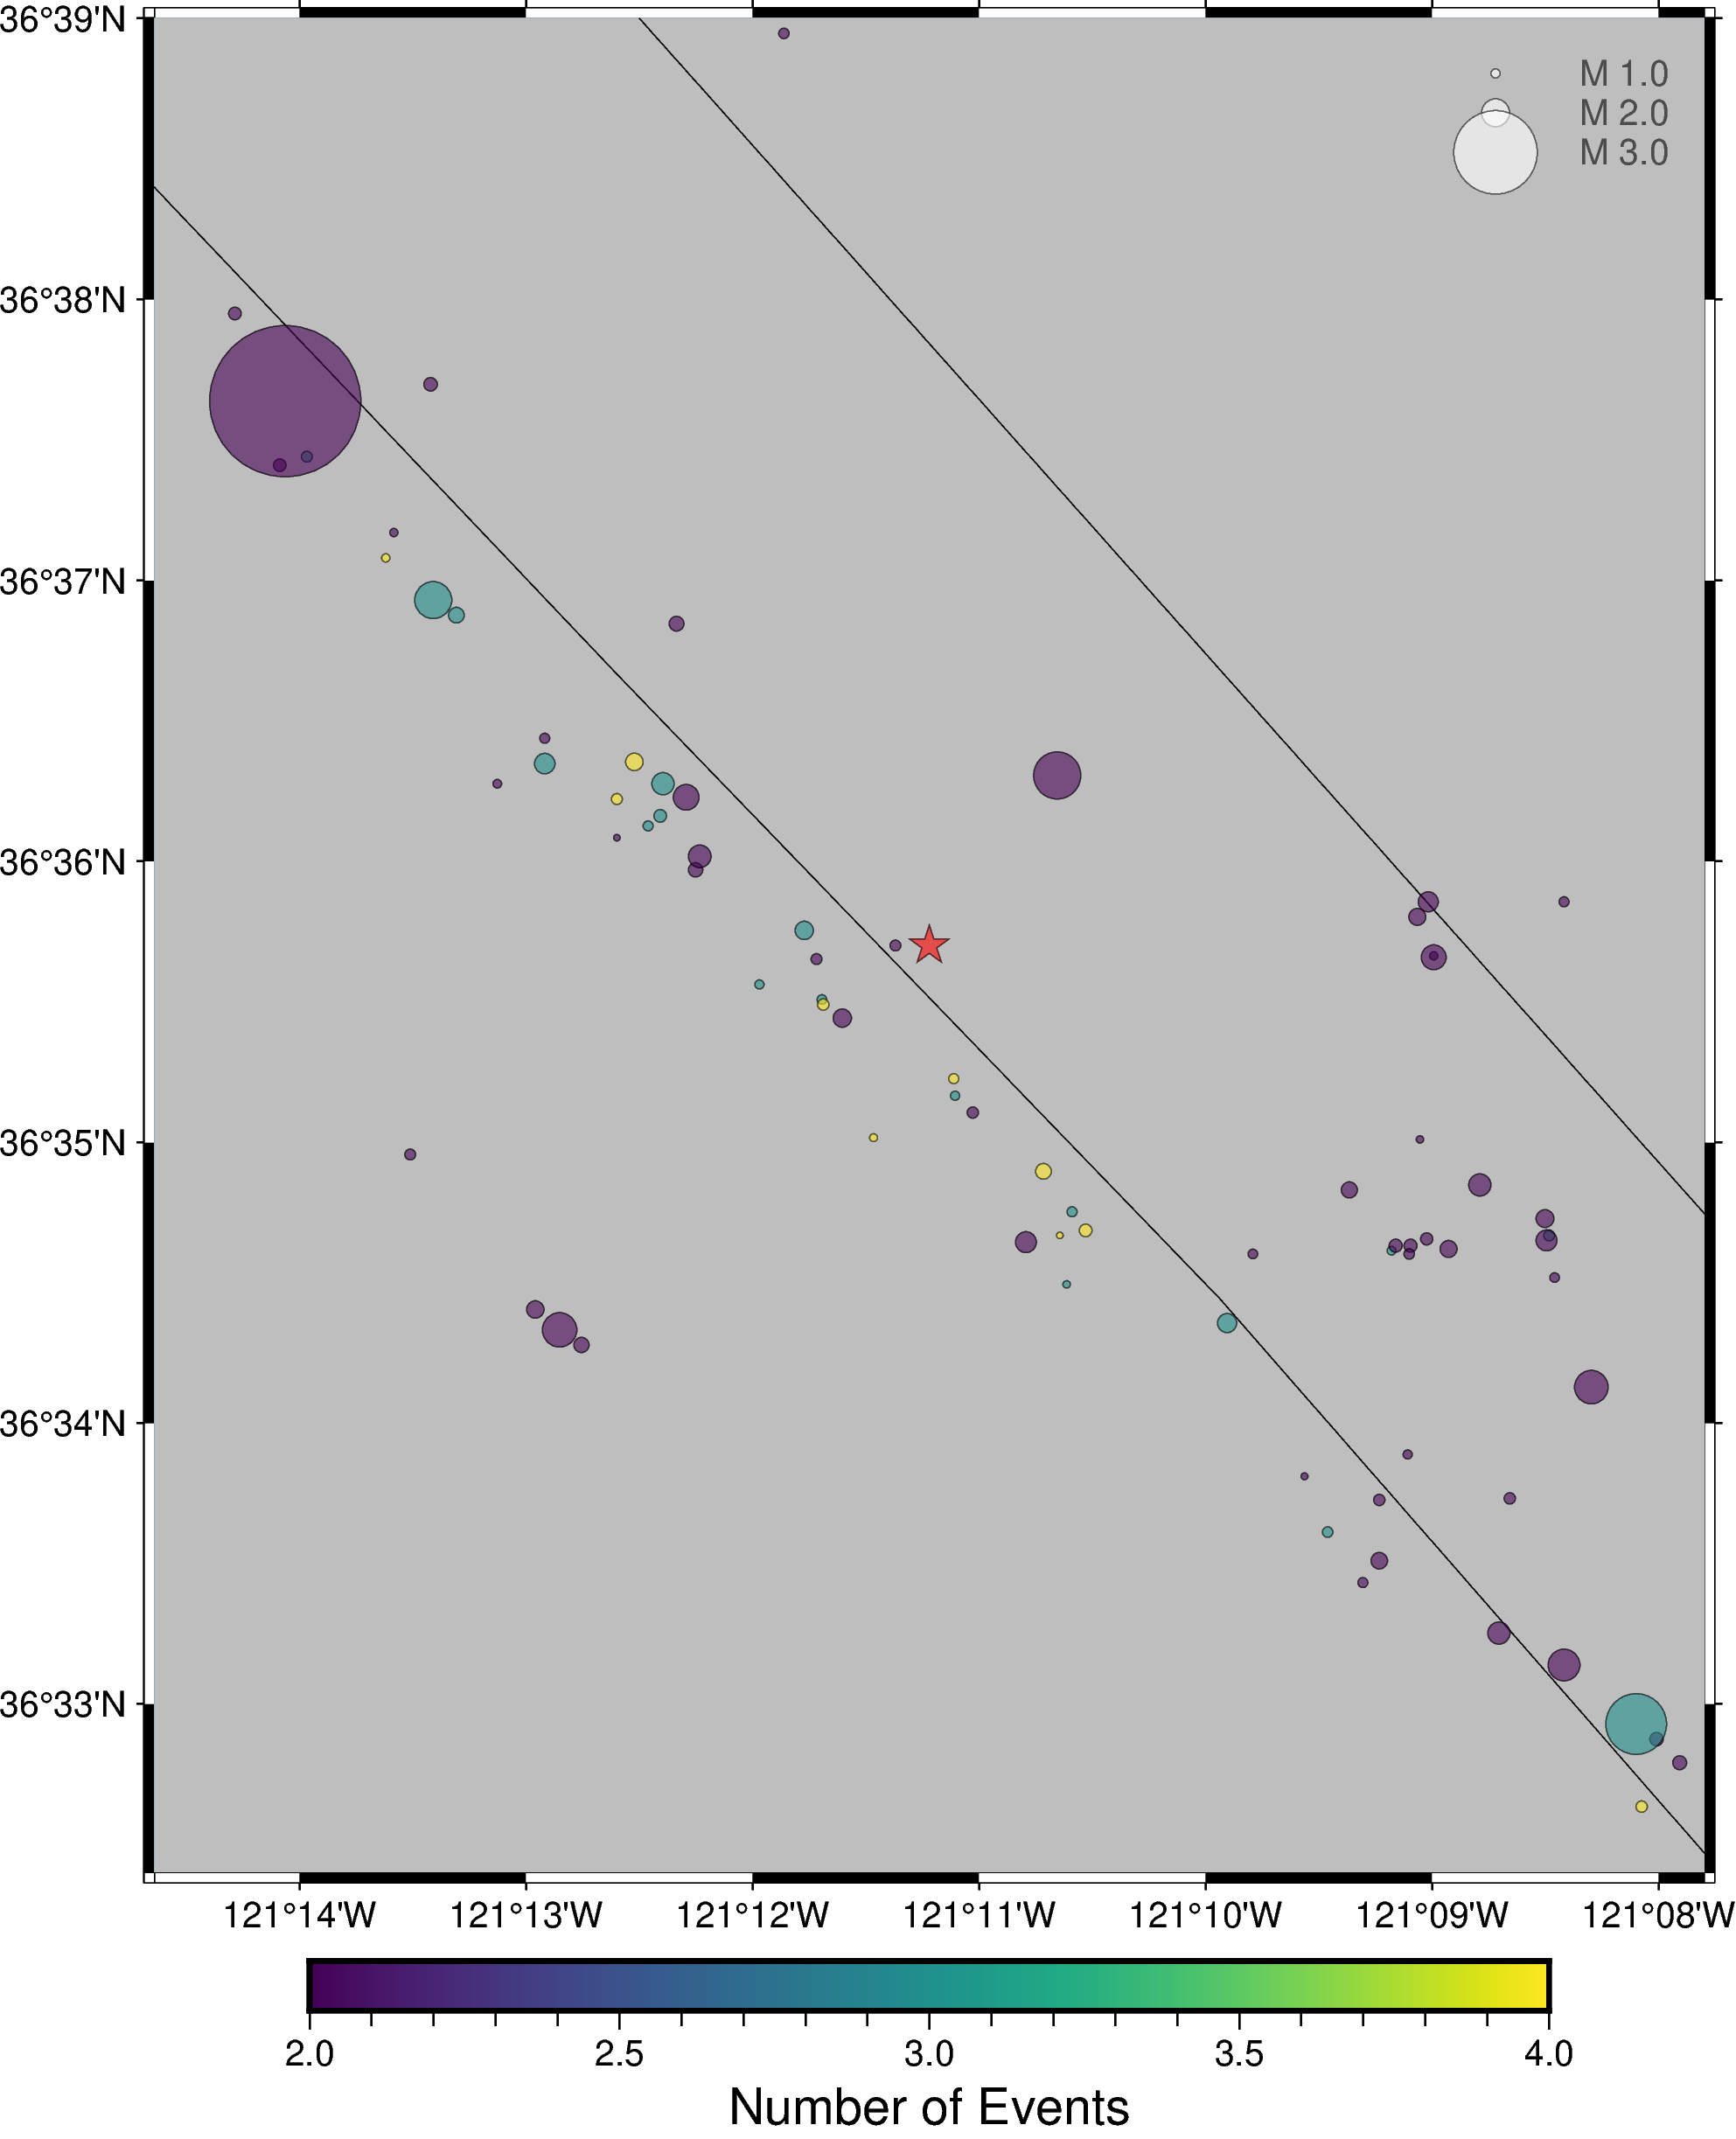

In [196]:
#plot window zoom
fig = pygmt.Figure()
fig.basemap(region=XMR_bounds, projection="M15c", frame=["a"])
fig.coast(land="gray", water="skyblue")
#faults
fig.plot(data=faults)
# plot sequences
pygmt.makecpt(cmap="viridis", series=[seq.NEV.min(), seq.NEV.max()])
fig.plot(x=seq["LONm"], y=seq["LATm"], size=0.03 * (3**seq["DMAGm"]), style="cc", color=seq.NEV, pen="black", cmap=True, transparency=40)
fig.colorbar(frame='af+l"Number of Events"')
# plot XMR1 station
fig.plot(x=-121.1870,y=36.5950, style="a0.4c", color="red",pen ="black", transparency=40)
# example sizes for legend
fig.plot(x=-120.0000,y=38.0000, color="white", style="c0.09c", pen="black", label="M 1.0")
fig.plot(x=-120.0000,y=38.0000, color="white", style="c0.27c", pen="black", label="M 2.0")
fig.plot(x=-120.0000,y=38.0000, color="white", style="c0.81c", pen="black", label="M 3.0")

# legend
fig.legend(position="JTR+jTR+o0.2c", transparency=40, projection="M15c")

fig.savefig(cwd + "/Watson_OCEA267_Final_1zoom.png")
fig.show()

In [194]:
print(max(seq["DMAGm"]))

3.54


# Set up Bins for Histogram

In [11]:
# timebin (trimonthly)
repbin_seq = []
for i in np.arange(1984, 2014):
    for j in np.arange(0,4):
        b = mdates.datestr2num("{}/{}/01".format(i,3+3*j))
        repbin_seq.append(b)

# Select Area Around XMR

In [12]:
sel_XMRLat = np.logical_and(seq["LATm"] >= XMR_bounds[2], seq["LATm"] <= XMR_bounds[3])
sel_XMRLon = np.logical_and(seq["LONm"] >= XMR_bounds[0], seq["LONm"] <= XMR_bounds[1])
seq_XMR = seq[sel_XMRLat][sel_XMRLon]
seq_XMR = seq_XMR.reset_index()

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\1609484064.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_XMR = seq[sel_XMRLat][sel_XMRLon]


In [17]:
#select events within window
for i in range(len(seq_XMR)):
    eq_XMR = rep_NC[rep_NC["seqID"]==seq_XMR["seqID"][i]]
    if i == 0:
        rep_XMR = eq_XMR
    else:
        rep_XMR = rep_XMR.append(eq_XMR)
rep_XMR = rep_XMR.reset_index()
# select non-aftershock sequences
# 1988
sel_after88 = np.logical_and(rep_XMR["YR"] == 1988, rep_XMR["MO"] >=7)
sel_after88 = np.logical_and(sel_after88, rep_XMR["MO"] <= 9)
sel_after88 = np.logical_and(sel_after88, rep_XMR["DEP"] <=4)
# 1995
sel_after95 = np.logical_and(rep_XMR["YR"] == 1995, rep_XMR["MO"] >=4)
sel_after95 = np.logical_and(sel_after95, rep_XMR["MO"] <=5)
sel_after95 = np.logical_and(sel_after95, rep_XMR["DEP"] >=4)
sel_after95 = np.logical_and(sel_after95, rep_XMR["DEP"] <=7)
# put together
sel_after = np.logical_or(sel_after88, sel_after95)
sel_noafter = np.logical_not(sel_after)

rep_XMR = rep_XMR[sel_noafter]
rep_XMR = rep_XMR.rename(columns={"level_0":"level_1"})
rep_XMR = rep_XMR.reset_index()
# set up time window (UTC)
t_win = np.zeros(len(rep_XMR))
for i in np.linspace(0,len(rep_XMR)-1,len(rep_XMR)).astype(int):
    t_win[i]=mdates.date2num(UTCDateTime(int(rep_XMR["YR"][i]),int(rep_XMR["MO"][i]),int(rep_XMR["DY"][i]),int(rep_XMR["HR"][i]),int(rep_XMR["MN"][i]),float(rep_XMR["SC"][i])))

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_XMR = rep_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\3343274695

# Plot Histogram and Extract Number of Events/Month

In [18]:
fig, ax = plt.subplots(1, figsize = (12,12))
n, bins, patches = plt.hist(t_win, bins = repbin_seq)
ax.set(title='Number Of Events vs. Time in (%.5f,%.5f,%.5f,%.5f)'%(XMR_bounds[0], XMR_bounds[1], XMR_bounds[2], XMR_bounds[3]))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
file_map = cwd+'/Watson_OCEA267_Final_2.png'
plt.savefig(file_map, dpi=150)
plt.show()

In [19]:
print(len(n), len(repbin_seq))

119 120


# Reduce Time Resolution of XMR1 to Match Cumul. Seismicity

In [20]:
idx = np.zeros(len(XMR1["DT"]))
for i in range(len(repbin_seq)):
    bool_date = XMR1["DT"] == repbin_seq[i]
    bool_date = np.array(bool_date).astype(int)
    idx = idx + bool_date
idx = idx.astype(bool)
XMR1M = XMR1[idx]
XMR1M = XMR1M.reset_index()

In [21]:
for i in range(len(XMR1M["DT"])):
    print(XMR1M["DT"][i], repbin_seq[i])

5173.0 5173.0
5265.0 5265.0
5357.0 5357.0
5448.0 5448.0
5538.0 5538.0
5630.0 5630.0
5722.0 5722.0
5813.0 5813.0
5903.0 5903.0
5995.0 5995.0
6087.0 6087.0
6178.0 6178.0
6268.0 6268.0
6360.0 6360.0
6452.0 6452.0
6543.0 6543.0
6634.0 6634.0
6726.0 6726.0
6818.0 6818.0
6909.0 6909.0
6999.0 6999.0
7091.0 7091.0
7183.0 7183.0
7274.0 7274.0
7364.0 7364.0
7456.0 7456.0
7548.0 7548.0
7639.0 7639.0
7729.0 7729.0
7821.0 7821.0
7913.0 7913.0
8004.0 8004.0
8095.0 8095.0
8187.0 8187.0
8279.0 8279.0
8370.0 8370.0
8460.0 8460.0
8552.0 8552.0
8644.0 8644.0
8735.0 8735.0
8825.0 8825.0
8917.0 8917.0
9009.0 9009.0
9100.0 9100.0
9190.0 9190.0
9282.0 9282.0
9374.0 9374.0
9465.0 9465.0
9556.0 9556.0
9648.0 9648.0
9740.0 9740.0
9831.0 9831.0
9921.0 9921.0
10013.0 10013.0
10105.0 10105.0
10196.0 10196.0
10286.0 10286.0
10378.0 10378.0
10470.0 10470.0
10561.0 10561.0
10651.0 10651.0
10743.0 10743.0
10835.0 10835.0
10926.0 10926.0
11017.0 11017.0
11109.0 11109.0
11201.0 11201.0
11292.0 11292.0
11382.0 11382.0
11

In [22]:
XMR1M = XMR1M[:-2]

In [23]:
for i in range(len(XMR1M["DT"])):
    print(XMR1M["DT"][i], repbin_seq[i])

5173.0 5173.0
5265.0 5265.0
5357.0 5357.0
5448.0 5448.0
5538.0 5538.0
5630.0 5630.0
5722.0 5722.0
5813.0 5813.0
5903.0 5903.0
5995.0 5995.0
6087.0 6087.0
6178.0 6178.0
6268.0 6268.0
6360.0 6360.0
6452.0 6452.0
6543.0 6543.0
6634.0 6634.0
6726.0 6726.0
6818.0 6818.0
6909.0 6909.0
6999.0 6999.0
7091.0 7091.0
7183.0 7183.0
7274.0 7274.0
7364.0 7364.0
7456.0 7456.0
7548.0 7548.0
7639.0 7639.0
7729.0 7729.0
7821.0 7821.0
7913.0 7913.0
8004.0 8004.0
8095.0 8095.0
8187.0 8187.0
8279.0 8279.0
8370.0 8370.0
8460.0 8460.0
8552.0 8552.0
8644.0 8644.0
8735.0 8735.0
8825.0 8825.0
8917.0 8917.0
9009.0 9009.0
9100.0 9100.0
9190.0 9190.0
9282.0 9282.0
9374.0 9374.0
9465.0 9465.0
9556.0 9556.0
9648.0 9648.0
9740.0 9740.0
9831.0 9831.0
9921.0 9921.0
10013.0 10013.0
10105.0 10105.0
10196.0 10196.0
10286.0 10286.0
10378.0 10378.0
10470.0 10470.0
10561.0 10561.0
10651.0 10651.0
10743.0 10743.0
10835.0 10835.0
10926.0 10926.0
11017.0 11017.0
11109.0 11109.0
11201.0 11201.0
11292.0 11292.0
11382.0 11382.0
11

# Smooth Seismicity data w/ moving avg filter

In [24]:
repbin_seq = repbin_seq[:len(XMR1M["DT"])]

In [25]:
n1 = n[:len(repbin_seq)]
n_f = uniform_filter1d(n1, size=8)

In [26]:
plt.figure()
plt.plot(repbin_seq, n1)
plt.plot(repbin_seq, n_f)
plt.show()

# Plot Both Time Series

In [144]:
# XMR Creep Time Series
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.plot(repbin_seq, n_f, 'b-',label="Burst-Like Repeating Seismicity")
ax1.set_xlabel('Year') 
ax1.set_ylabel('Number of Events', color = 'blue')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax1.tick_params(axis ='y', labelcolor = 'blue') 
ax1.set(title='Time Series of XMR Creepmeter & Surrounding Burst-Like Repeating Seismicity')
plt.grid(axis='x')
plt.legend(loc='upper left')
ax2 = ax1.twinx() 
ax2.plot(XMR1M["DT"], XMR1M["DIST"], 'red',label="XMR1 Creepmeter")
ax2.set_ylabel('Creep (mm)', color = 'red') 
ax2.tick_params(axis ='y', labelcolor = 'red') 
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
plt.legend(loc='upper right')
file_map = cwd+'/Watson_OCEA267_Final_3.png'
plt.savefig(file_map, dpi=150)
plt.show()

# Fit Models to XMR1M Time Series

In [28]:
# Start w/ OLS
X = sm.add_constant(pd.DataFrame(XMR1M["DT"]))
XMR_OLS = sm.OLS(XMR1M["DIST"], X).fit()

In [29]:
# residual independence?
print(durbin_watson(XMR_OLS.resid))

0.3945809367097392


In [30]:
# autocorrelation --> plot acf
plt.figure()
plot_acf(XMR_OLS.resid, title='ACF of OLS Residuals')
plt.show()

# tails off slowly

In [31]:
# pacf
plt.figure()
plot_pacf(XMR_OLS.resid, title='PACF of OLS Residuals')
plt.show()

# cuts off after lag 1 or 2

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


In [32]:
# create sigma vector
res1 = list(XMR_OLS.resid[2:])
res2 = list(XMR_OLS.resid[0:-2])
res_fit = sm.OLS(res1, res2).fit()
rho = res_fit.params
order = toeplitz(np.arange(len(XMR_OLS.resid)))
sigma = rho**order

In [33]:
# fit GLS w/ sigma
XMR_GLS = sm.GLS(XMR1M["DIST"],X,sigma=sigma).fit()

In [34]:
# Normality & Constant Variance?
# Shapiro Wilk --> normality
print(shapiro(XMR_GLS.resid))

ShapiroResult(statistic=0.9853434562683105, pvalue=0.24563068151474)


In [35]:
plt.figure()
plt.hist(XMR_GLS.resid, bins= np.linspace(-20,20,40))
plt.xlabel("Residuals (mm)")
plt.savefig(cwd+"/Watson_OCEA267_Final_S3.png")
plt.show()

In [36]:
# Bartlett --> Variance
res1 = XMR_GLS.resid[0:int(len(XMR_GLS.resid)/2)]
res2 = XMR_GLS.resid[int(len(XMR_GLS.resid)/2)+1:]
print(bartlett(res1,res2))

# No Constant Variance, try to explain in the paper

BartlettResult(statistic=16.200583350538214, pvalue=5.697656815299412e-05)


In [37]:
# plot model fit & residuals
fig, (ax1, ax2) = plt.subplots(2,1,sharex='col',figsize = (8,9))
ax1.plot(XMR1M["DT"], XMR1M["DIST"], label="XMR1 Time Series")
ax1.plot(XMR1M["DT"], XMR_GLS.fittedvalues, label="GLS-fitted Model")
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax1.grid()
plt.xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
ax1.title.set_text("GLS-Fitted XMR1 Linear Regression Model")
plt.xlabel("Year")
ax1.set_ylabel("Creep (mm)")
ax2.plot(repbin_seq, XMR_GLS.resid)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax2.title.set_text("Residuals of GLS-Fitted XMR1 Model")
ax2.set_ylabel("Creep (mm)")
ax2.grid()
ax1.legend()
plt.savefig(cwd+"/Watson_OCEA267_Final_4.png", dpi=150)
plt.show()

In [38]:
XMR_GLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                   DIST   R-squared:                       0.997
Model:                            GLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.181e+04
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          5.05e-147
Time:                        11:20:51   Log-Likelihood:                -297.77
No. Observations:                 115   AIC:                             599.5
Df Residuals:                     113   BIC:                             605.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.7972      2.373     19.717      0.000      42.095      51.500
DT             0.0448      0.000    204.484      0.000       0.044       0.045
==============================================================================
Omnibus:                        1.839   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.399   Jarque-Bera (JB):                1.415
Skew:                           0.063   Prob(JB):                        0.493
Kurtosis:                       3.529   Cond. No.                     3.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Plot two residuals against one another

In [145]:
fig, ax = plt.subplots(1, figsize = (12,12))
ax.plot(XMR1M["DT"], XMR_GLS.resid, label="Detrended Creepmeter")
ax.plot(repbin_seq, n_f, label="Burst-Like Repeating Seismicity")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
plt.grid(axis='x')
ax.set_xlabel("Time (Year)")
plt.savefig(cwd+"/figures/series_comparison.png", dpi=150)
plt.show()

# Find Correlation Coefficient of Model Residuals

In [127]:
# create pearson correlation function
corr = np.zeros(17)
lags = np.arange(-((corr.size - 1)/2), (corr.size/2)).astype(int)
for i in range(17):
    if i <=7:
        pc = pearsonr(n_f[:lags[i]], XMR_GLS.resid[-(lags[i]):])
    elif i == 8:
        pc = pearsonr(n_f, XMR_GLS.resid)
    elif i >= 9:
        pc = pearsonr(n_f[lags[i]:], XMR_GLS.resid[:-(lags[i])])
    corr[i] = pc[0]

# corr = corr/n_f.size #biased
# corr /= (n_f.size - abs(lags)) # unbiased

plt.figure()
plt.plot(lags, corr)
#plt.title("Cross-Correlation Function of Number of Burst-Like Repeating Events & Detrended Creep")
plt.xlabel("Lag")
plt.ylabel("Pearson-Correlation")
plt.savefig(cwd + "/Watson_Final_CC.png", dpi=150)
plt.show()

In [113]:
maxcorr = corr[corr == max(corr)]
maxlag = lags[corr == max(corr)]
print("Maximum Pearson correlation is %f at lag of %i months"%(maxcorr[0], abs(maxlag[0])*3))

Maximum Pearson correlation is 0.521349 at lag of 18 months


In [146]:
plt.figure()
plt.scatter(n_f[:maxlag[0]],XMR_GLS.resid[-(maxlag[0]):])
plt.xlabel("Burst-Like Repeating Seismicity")
plt.ylabel("Detrended XMR Creep (mm)")
plt.savefig(cwd+ "/Watson_Final_lagrelationship.png", dpi=150)
plt.show()

In [148]:
fig, ax = plt.subplots(1, figsize = (12,12))
ax.plot(XMR1M["DT"][-(maxlag[0]):], XMR_GLS.resid[-(maxlag[0]):], label="Detrended XMR1")
ax.plot(repbin_seq[-(maxlag[0]):], n_f[:maxlag[0]], label="Burst-Like Repeating Seismicity")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
plt.grid(axis='x')
plt.legend()
plt.xlabel("Time (Year)")
#plt.title("Comparison of Detrended Creep and Burst-Like Repeating Seismicity with Corrected Lag")
plt.savefig(cwd + '/Watson_Final_lagcorrected.png', dpi=150)
plt.show()

In [116]:
print(pearsonr(n_f[:maxlag[0]], XMR_GLS.resid[-(maxlag[0]):]))

(0.5213485467623041, 6.1557604185845675e-09)


In [117]:
print(pearsonr(n_f, XMR_GLS.resid))

(0.053324501422584186, 0.5713954612443691)


# Plot 4 Subplots: Model Residuals Without Lag, Model Residuals With Lag, and their Relationships

In [149]:
fig, axs = plt.subplots(2,2, sharey="row",figsize = (19,10))
axs[0,0].plot(XMR1M["DT"], XMR_GLS.resid,label="XMR1")
axs[0,0].plot(repbin_seq, n_f,label="Cumul. Seis")
axs[0,0].xaxis.set_major_locator(mdates.YearLocator())
axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
axs[0,0].set_xlabel("Year")
axs[0,0].grid()
axs[0,0].set_xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
axs[0,0].title.set_text("No Lag")
axs[0,0].legend()
axs[0,1].plot(XMR1M["DT"][-(maxlag[0]):], XMR_GLS.resid[-(maxlag[0]):], label="XMR1")
axs[0,1].plot(repbin_seq[-(maxlag[0]):], n_f[:maxlag[0]], label="Cumul. Seis")
axs[0,1].xaxis.set_major_locator(mdates.YearLocator())
axs[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
axs[0,1].set_xlim(mdates.datestr2num(['1984/01/01','2010/10/01']))
axs[0,1].title.set_text("With Lag")
axs[0,1].set_xlabel("Year")
axs[0,1].grid()
axs[0,1].legend()
axs[1,0].scatter(n_f,XMR_GLS.resid)
#axs[1,0].set_title("With Lag")
axs[1,0].set_xlabel("Burst-Like Repeating Seismicity (# Events)")
axs[1,0].set_ylabel("Detrended XMR Creep (mm)")
axs[1,0].grid()
axs[1,0].legend()
axs[1,1].scatter(n_f[:maxlag[0]],XMR_GLS.resid[-(maxlag[0]):])
#axs[1,1].set_title("Cumulative Seismicity Residuals vs. XMR1 Residuals with Corrected Time Lag")
axs[1,1].set_xlabel("Burst-Like Repeating Seismicity (# Events)")
axs[1,1].set_ylabel("Detrended XMR Creep (mm)")
axs[1,1].grid()
axs[1,1].legend()
plt.savefig(cwd+"/Watson_OCEA267_Final_TimeSeriesComparison.png", dpi=150)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Try Fitting With Characteristic Repeaters

# Select Area Around XMR1

In [58]:
sel_XMRLat = np.logical_and(char["LATm"] >= XMR_bounds[2], char["LATm"] <= XMR_bounds[3])
sel_XMRLon = np.logical_and(char["LONm"] >= XMR_bounds[0], char["LONm"] <= XMR_bounds[1])
char_XMR = char[sel_XMRLat][sel_XMRLon]
char_XMR = char_XMR.reset_index()

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\1273816755.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  char_XMR = char[sel_XMRLat][sel_XMRLon]


In [59]:
for i in range(len(char_XMR)):
    eq_XMR = rep_NC[rep_NC["seqID"]==char_XMR["seqID"][i]]
    if i == 0:
        nb_XMR = eq_XMR
    else:
        nb_XMR = nb_XMR.append(eq_XMR)
nb_XMR = nb_XMR.reset_index()
t_nb = np.zeros(len(nb_XMR))

for i in np.linspace(0,len(nb_XMR)-1,len(nb_XMR)).astype(int):
    t_nb[i]=mdates.date2num(UTCDateTime(int(nb_XMR["YR"][i]),int(nb_XMR["MO"][i]),int(nb_XMR["DY"][i]),int(nb_XMR["HR"][i]),int(nb_XMR["MN"][i]),float(nb_XMR["SC"][i])))
fig, ax = plt.subplots(1, figsize = (12,12))

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_XMR = nb_XMR.append(eq_XMR)
C:\Users\awhip\AppData\Local\Temp\ipykernel_15476\2465405448.py:6: F

In [60]:
# timebin (trimonthly)
repbin_seq = []
for i in np.arange(1984, 2014):
    for j in np.arange(0,4):
        b = mdates.datestr2num("{}/{}/01".format(i,3+3*j))
        repbin_seq.append(b)

# Map Figures

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


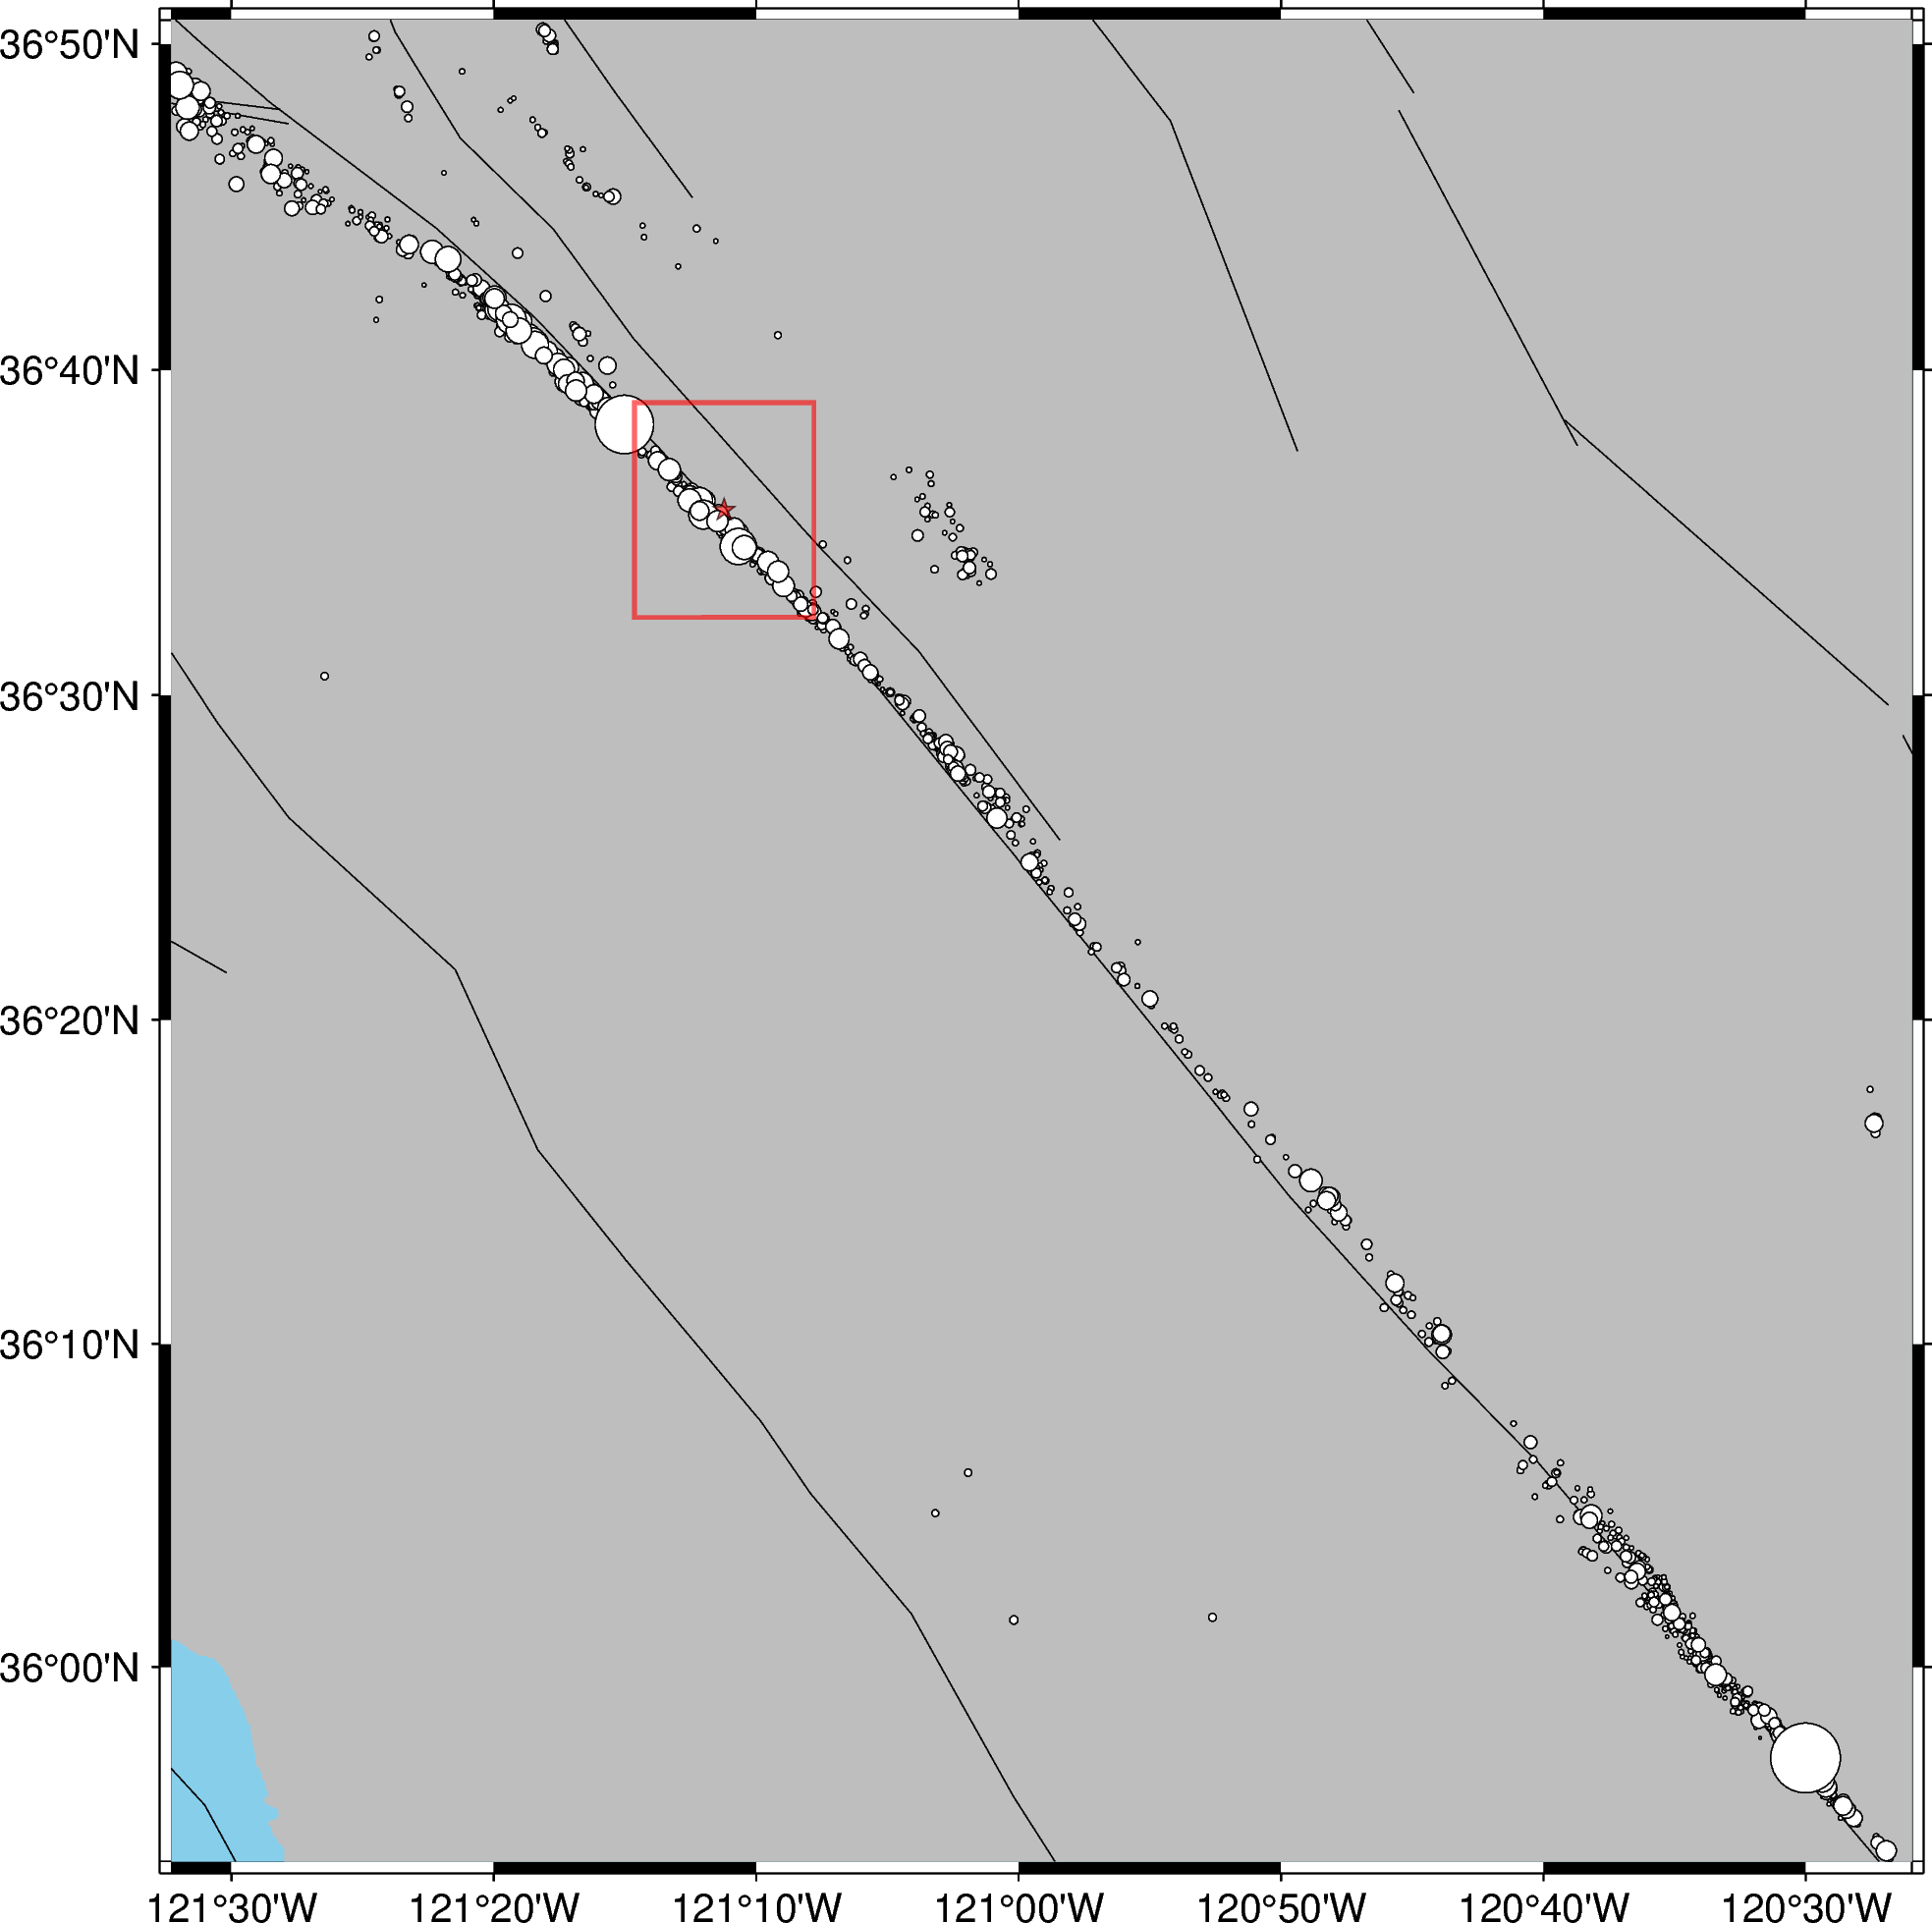

In [191]:
# read faults data for plotting
faults = gpd.read_file(cwd+"/faults/gem_active_faults.shp")
#plot
fig = pygmt.Figure()
fig.basemap(region=NC_bounds, projection="M15c", frame=["a"])
fig.coast(land="gray", water="skyblue")
#faults
fig.plot(data=faults)
# plot sequences
fig.plot(x=char["LONm"], y=char["LATm"], size=0.02 * (2**char["DMAGm"]),style="cc", color="white", pen="black")
# plot window for data being considered
fig.plot(x=XMR_lon,y=XMR_lat, pen = "1p,red", transparency=40)
# plot XMR1 station
fig.plot(x=-121.1870,y=36.5950, style="a0.2c", color="red",pen ="black", transparency=40)
fig.savefig(cwd + "/Watson_OCEA267_Final_1_char.png")
fig.show()

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


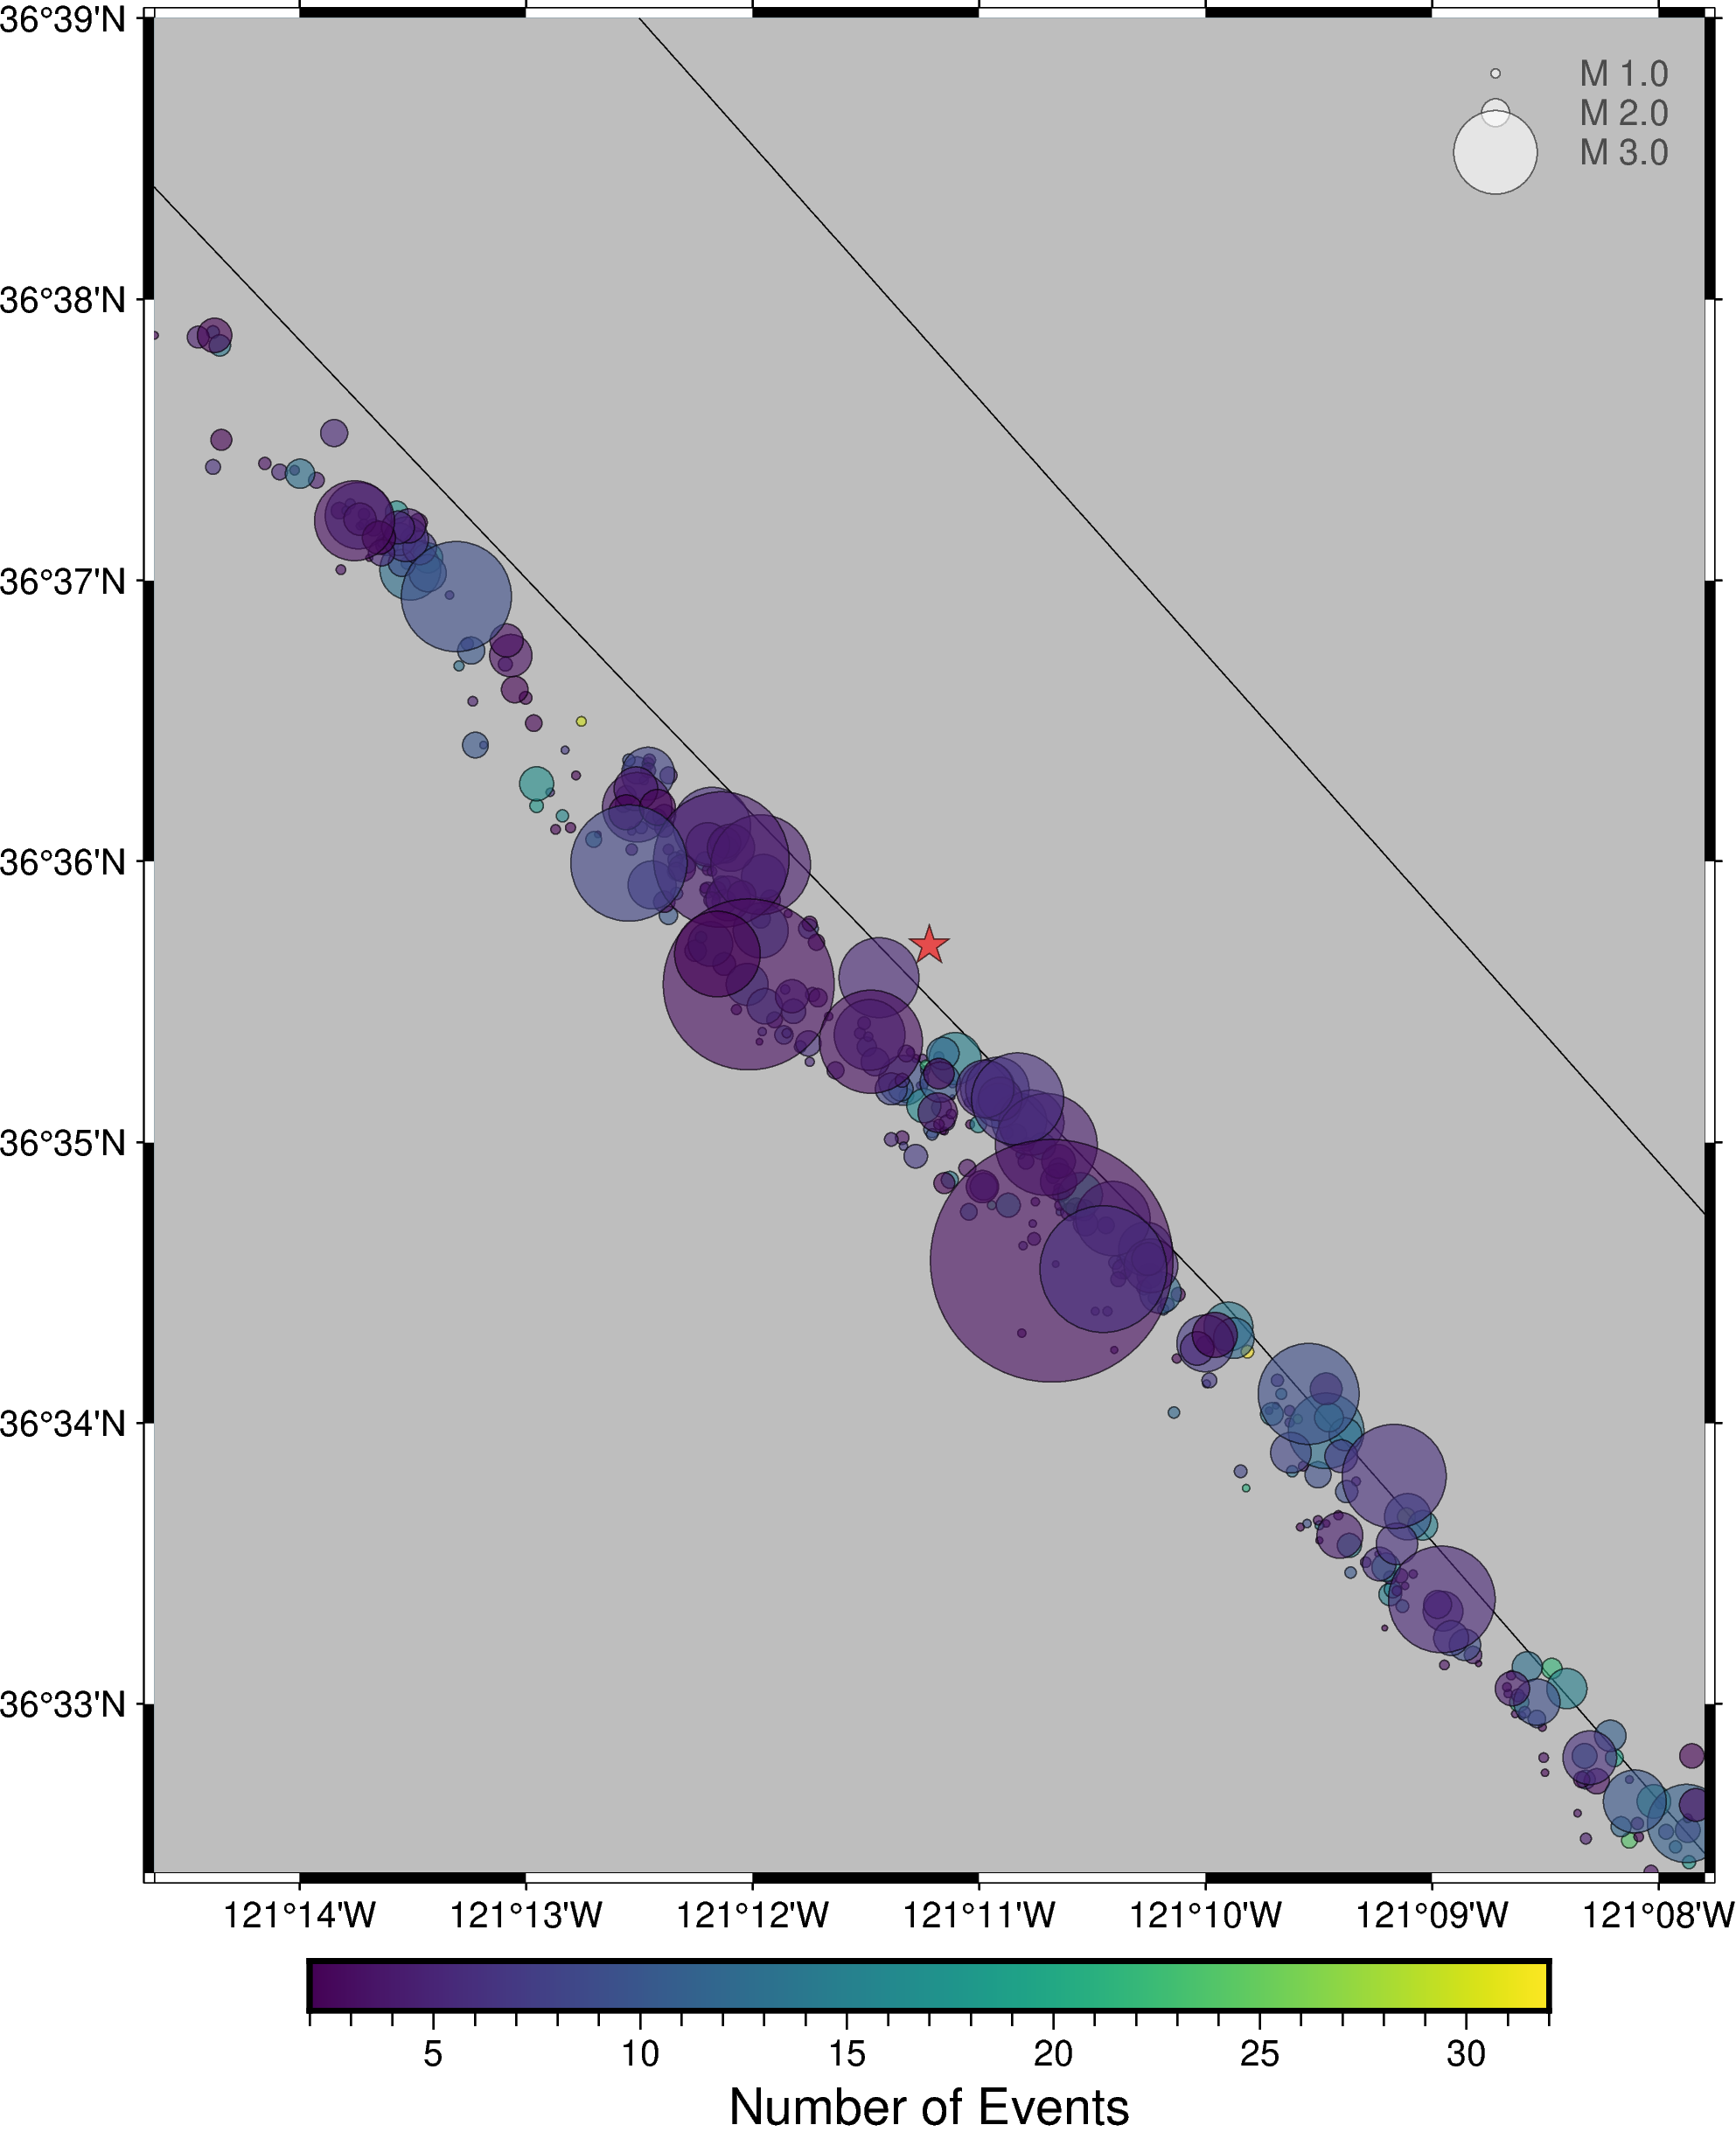

In [190]:
#plot window zoom
fig = pygmt.Figure()
fig.basemap(region=XMR_bounds, projection="M15c", frame=["a"])
fig.coast(land="gray", water="skyblue")
#faults
fig.plot(data=faults)
# plot sequences
pygmt.makecpt(cmap="viridis", series=[char.NEV.min(), char.NEV.max()])
fig.plot(x=char["LONm"], y=char["LATm"], size=0.03 * (3**char["DMAGm"]), style="cc", color=char.NEV, pen="black", cmap=True, transparency=40)
fig.colorbar(frame='af+l"Number of Events"')
# plot XMR1 station
fig.plot(x=-121.1870,y=36.5950, style="a0.4c", color="red",pen ="black", transparency=40)
# example sizes for legend
fig.plot(x=-120.0000,y=38.0000, color="white", style="c0.09c", pen="black", label="M 1.0")
fig.plot(x=-120.0000,y=38.0000, color="white", style="c0.27c", pen="black", label="M 2.0")
fig.plot(x=-120.0000,y=38.0000, color="white", style="c0.81c", pen="black", label="M 3.0")
# legend
fig.legend(position="JTR+jTR+o0.2c", transparency=40, projection="M15c")
fig.savefig(cwd + "/Watson_OCEA267_Final_1zoom_char.png")
fig.show()

# Histogram of Events

In [134]:
fig, ax = plt.subplots(1, figsize = (12,12))
n_nb, bins, patches = plt.hist(t_nb, bins = repbin_seq)
ax.set(title='Number Of Characteristic Repeating Events vs. Time in (%.5f,%.5f,%.5f,%.5f)'%(XMR_bounds[0], XMR_bounds[1], XMR_bounds[2], XMR_bounds[3]))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
file_map = cwd+'/Watson_OCEA267_Final_2_char.png'
plt.savefig(file_map, dpi=150)
plt.show()

# Moving Avg Filter of Seismicity

In [62]:
repbin_seq = repbin_seq[:len(XMR1M["DT"])]
n2 = n_nb[:len(repbin_seq)]
n_f_nb = uniform_filter1d(n2, size=8)

# test plot
plt.figure()
plt.plot(repbin_seq, n2)
plt.plot(repbin_seq, n_f_nb)
plt.show()

# Plot Both Datasets

In [141]:
# XMR Creep Time Series
fig, ax1 = plt.subplots(figsize = (16,9))
ax1.plot(repbin_seq, n_f_nb, 'b-',label="Characteristic Repeating Seismicity")
ax1.set_xlabel('Year') 
ax1.set_ylabel('Number of Events', color = 'blue')
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
ax1.tick_params(axis ='y', labelcolor = 'blue') 
ax1.set(title='Time Series of XMR Creepmeter & Surrounding Characteristic Repeating Seismicity')
plt.grid(axis='x')
plt.legend(loc='upper left')
ax2 = ax1.twinx() 
ax2.plot(XMR1M["DT"], XMR1M["DIST"], 'red',label="XMR1 Creepmeter")
ax2.set_ylabel('Creep (mm)', color = 'red') 
ax2.tick_params(axis ='y', labelcolor = 'red') 
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
plt.legend(loc='upper right')
file_map = cwd+'/Watson_OCEA267_Final_3_char.png'
plt.savefig(file_map, dpi=150)
plt.show()

# Correlation Coefficient

In [126]:
# create pearson correlation function
corr_nb = np.zeros(17)
lags_nb = np.arange(-((corr.size - 1)/2), (corr.size/2)).astype(int)
for i in range(17):
    if i <=7:
        pc = pearsonr(n_f_nb[:lags[i]], XMR_GLS.resid[-(lags[i]):])
    elif i == 8:
        pc = pearsonr(n_f_nb, XMR_GLS.resid)
    elif i >= 9:
        pc = pearsonr(n_f_nb[lags[i]:], XMR_GLS.resid[:-(lags[i])])
    corr_nb[i] = pc[0]

# corr = corr/n_f.size #biased
# corr_nb /= (n_f_nb.size - abs(lags)) # unbiased

plt.figure()
plt.plot(lags_nb, corr_nb)
#plt.title("Cross-Correlation Function of Number of Characteristic Events & Detrended Creep")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.savefig(cwd + "/Watson_Final_CC_char.png", dpi=150)
plt.show()

In [125]:
maxcorr_nb = corr_nb[corr_nb == max(corr_nb)]
maxlag_nb = lags_nb[corr_nb == max(corr_nb)]
print("Maximum Pearson correlation is %f at lag of %i months"%(maxcorr_nb[0], abs(maxlag_nb[0])*3))

Maximum Pearson correlation is 0.575962 at lag of 21 months


In [122]:
plt.figure()
plt.scatter(n_f_nb[:maxlag_nb[0]],XMR_GLS.resid[-(maxlag_nb[0]):])
plt.xlabel("Repeating Characteristic Seismicity")
plt.ylabel("Detrended XMR Creep (mm)")
plt.savefig(cwd+ "Watson_Final_lagrelationship_char.png", dpi=150)
plt.show()

In [142]:
fig, ax = plt.subplots(1, figsize = (12,12))
ax.plot(XMR1M["DT"][-(maxlag_nb[0]):], XMR_GLS.resid[-(maxlag_nb[0]):], label="Detrended XMR1")
ax.plot(repbin_seq[-(maxlag_nb[0]):], n_f_nb[:maxlag_nb[0]], label="Characteristic Repeating Seismicity")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
plt.grid(axis='x')
plt.legend()
plt.xlabel("Time (Year)")
#plt.title("Comparison of Detrended Creep and Burst-Like Repeating Seismicity with Corrected Lag")
plt.savefig(cwd + 'Watson_Final_lagcorrected_char.png', dpi=150)
plt.show()

In [124]:
print(pearsonr(n_f_nb[:maxlag_nb[0]], XMR_GLS.resid[-(maxlag_nb[0]):]))

(0.5759615496927029, 6.958320284398728e-11)


In [166]:
fig, axs = plt.subplots(2,2, sharey="row",figsize = (19,10))
axs[0,0].plot(XMR1M["DT"], XMR_GLS.resid,label="XMR1")
axs[0,0].plot(repbin_seq, n_f_nb,label="Characteristic Seis")
axs[0,0].xaxis.set_major_locator(mdates.YearLocator())
axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
axs[0,0].set_xlabel("Year")
axs[0,0].grid()
axs[0,0].set_xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
axs[0,0].title.set_text("No Lag")
axs[0,0].legend()
axs[0,1].plot(XMR1M["DT"][-(maxlag_nb[0]):], XMR_GLS.resid[-(maxlag_nb[0]):], label="XMR1")
axs[0,1].plot(repbin_seq[-(maxlag_nb[0]):], n_f_nb[:maxlag_nb[0]], label="Characteristic Seis")
axs[0,1].xaxis.set_major_locator(mdates.YearLocator())
axs[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
axs[0,1].set_xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
axs[0,1].title.set_text("With Lag")
axs[0,1].set_xlabel("Year")
axs[0,1].grid()
axs[0,1].legend()
axs[1,0].scatter(n_f_nb,XMR_GLS.resid)
#axs[1,0].set_title("With Lag")
axs[1,0].set_xlabel("Characteristic Repeating Seismicity (# Events)")
axs[1,0].set_ylabel("Detrended XMR Creep (mm)")
axs[1,0].grid()
axs[1,0].legend()
axs[1,1].scatter(n_f_nb[:maxlag_nb[0]],XMR_GLS.resid[-(maxlag_nb[0]):])
#axs[1,1].set_title("Cumulative Seismicity Residuals vs. XMR1 Residuals with Corrected Time Lag")
axs[1,1].set_xlabel("Characteristic Repeating Seismicity (# Events)")
axs[1,1].set_ylabel("Detrended XMR Creep (mm)")
axs[1,1].grid()
axs[1,1].legend()
plt.savefig(cwd+"/Watson_OCEA267_Final_TimeSeriesComparison_char.png", dpi=150)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Check Correlation between Burst-Like and Characteristic Seismicity

In [160]:
# create pearson correlation function
corr_rep = np.zeros(17)
lags_rep = np.arange(-((corr_rep.size - 1)/2), (corr_rep.size/2)).astype(int)
for i in range(17):
    if i <=7:
        pc = pearsonr(n_f[:lags[i]], n_f_nb[-(lags[i]):])
    elif i == 8:
        pc = pearsonr(n_f, n_f_nb)
    elif i >= 9:
        pc = pearsonr(n_f[lags[i]:], n_f_nb[:-(lags[i])])
    corr_rep[i] = pc[0]

# corr = corr/n_f.size #biased
# corr /= (n_f.size - abs(lags)) # unbiased

plt.figure()
plt.plot(lags_rep, corr_rep)
#plt.title("Cross-Correlation Function of Number of Burst-Like Repeating Events & Detrended Creep")
plt.xlabel("Lag")
plt.ylabel("Pearson-Correlation")
plt.savefig(cwd + "/Watson_Final_CC_rep.png", dpi=150)
plt.show()

In [170]:
print(pearsonr(n_f[1:], n_f_nb[:-1]))

(0.602075319788924, 1.1008166833533174e-12)


In [167]:
fig, axs = plt.subplots(2,2, sharey="row",figsize = (19,10))
axs[0,0].plot(repbin_seq, n_f,label="Burst-Like Seis")
axs[0,0].plot(repbin_seq, n_f_nb,label="Characteristic Seis")
axs[0,0].xaxis.set_major_locator(mdates.YearLocator())
axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
axs[0,0].set_xlabel("Year")
axs[0,0].grid()
axs[0,0].set_xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
axs[0,0].title.set_text("No Lag")
axs[0,0].legend()
axs[0,1].plot(repbin_seq[1:], n_f[1:], label="Burst-Like Seis")
axs[0,1].plot(repbin_seq[1:], n_f_nb[:-1], label="Characteristic Seis")
axs[0,1].xaxis.set_major_locator(mdates.YearLocator())
axs[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%y'))
axs[0,1].set_xlim(mdates.datestr2num(['1984/01/01','2012/10/01']))
axs[0,1].title.set_text("With Lag")
axs[0,1].set_xlabel("Year")
axs[0,1].grid()
axs[0,1].legend()
axs[1,0].scatter(n_f_nb,n_f)
#axs[1,0].set_title("With Lag")
axs[1,0].set_xlabel("Characteristic Repeating Seismicity (# Events)")
axs[1,0].set_ylabel("Detrended XMR Creep (mm)")
axs[1,0].grid()
axs[1,0].legend()
axs[1,1].scatter(n_f_nb[:-1],n_f[1:])
#axs[1,1].set_title("Cumulative Seismicity Residuals vs. XMR1 Residuals with Corrected Time Lag")
axs[1,1].set_xlabel("Characteristic Repeating Seismicity (# Events)")
axs[1,1].set_ylabel("Detrended XMR Creep (mm)")
axs[1,1].grid()
axs[1,1].legend()
plt.savefig(cwd+"/Watson_OCEA267_Final_TimeSeriesComparison_rep.png", dpi=150)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Check Mean/Median Depth of Burst-Like vs. Characteristic

In [169]:
# mean depth
print("""
Mean Depth:
Burst-Like: %f km
Characteristic: %f km
"""%(np.mean(rep_XMR["DEP"]),np.mean(nb_XMR["DEP"])))

# median depth
print("""
Median Depth:
Burst-Like: %f km
Characteristic: %f km
"""%(np.median(rep_XMR["DEP"]),np.median(nb_XMR["DEP"])))


Mean Depth:
Burst-Like: 6.102939 km
Characteristic: 5.369883 km


Median Depth:
Burst-Like: 5.772000 km
Characteristic: 5.745000 km

